# Part 1: Model a deep feed forward network for regression.

## Step 1-2: Data Creation

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

def generate_data(N, noise_std=0.001):
    # Generate random inputs in range [-1,1]
    X = np.random.uniform(-1, 1, (N, 8))
    x1, x2, x3, x4, x5, x6, x7, x8 = X.T

    y = np.zeros((N, 5))

    y[:, 0] = 2*x1*x3 - x1*x5 + x3*x8 + 2*x2**2*x8 + x5
    y[:, 1] = x1*x5*x6 - x3*x4 - 3*x2*x3 + 2*x2**2*x4 - 2*x7*x8 - 1
    y[:, 2] = 2*x3**2 - x5*x7 - 3*x1*x4*x6 + x1**2*x2*x4 - 1
    y[:, 3] = -x6**3 + 2.1*x1*x3*x8 - x1*x4*x7 - 3.2*x5**2*x2*x4 - x8
    y[:, 4] = x1**2*x5 - 3*x3*x4*x8 + x1*x2*x4 - 3*x6 + x1**2*x7 + 2

    # Add Gaussian noise
    y += np.random.normal(0, noise_std, y.shape)

    return X, y

# Generate training and validation data
N_train = 1000
N_val = 500
X_train, y_train = generate_data(N_train, noise_std=0.001) # Noise added to training data
X_val, y_val = generate_data(N_val, noise_std=0.0) # No noise in validation data

## Step 3-4-5: Build a Feedforward Network with 3 Hidden Layers

In [2]:
def build_model(layer_sizes=[6, 6, 6], activations=['relu', 'tanh', 'sigmoid'], learning_rate=0.01):
    model = keras.Sequential([
        layers.Input(shape=(8,)),
        layers.Dense(layer_sizes[0], activation=activations[0]),
        layers.Dense(layer_sizes[1], activation=activations[1]),
        layers.Dense(layer_sizes[2], activation=activations[2]),
        layers.Dense(5)
    ])

    model.compile(optimizer=keras.optimizers.SGD(learning_rate=learning_rate), loss='mse', metrics=['mae'])

    return model

def plot_train_val_loss(history, title='Training vs Validation Loss'):
    # Plot training & validation loss values
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9768 - mae: 0.7428
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0150 - mae: 0.7614 
Training Loss: 0.9912, Training MAE: 0.7478
Validation Loss: 1.0186, Validation MAE: 0.7690


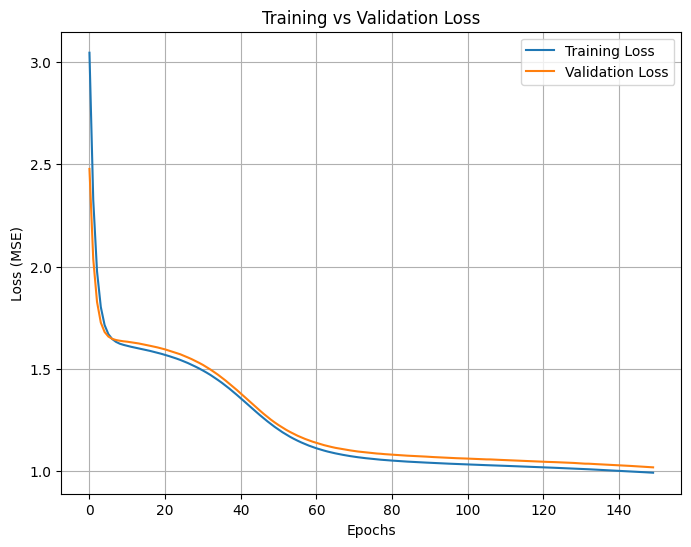

In [3]:
model = build_model()
history = model.fit(X_train, y_train, epochs=150, validation_data=(X_val, y_val), batch_size=32, verbose=0)

# Evaluate the final performance
train_loss, train_mae = model.evaluate(X_train, y_train)
val_loss, val_mae = model.evaluate(X_val, y_val)

print(f"Training Loss: {train_loss:.4f}, Training MAE: {train_mae:.4f}")
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

plot_train_val_loss(history)

## Step 6-7: Experiment with Different Activation Functions, Learning Rates, and Epochs

In [5]:
from tabulate import tabulate

activation_combinations = [
    ['relu', 'tanh', 'sigmoid'],
    ['tanh', 'sigmoid', 'relu'],
    ['elu', 'relu', 'softplus']
]

learning_rates = [0.01, 0.005, 0.001]
epoch_counts = [150, 225, 337]  # 50% increase

best_params = None
best_val_loss = float('inf')

results = []  # Store results for tabulation

for activations in activation_combinations:
    for lr in learning_rates:
        for epochs in epoch_counts:
            model = build_model(layer_sizes=[6, 6, 6], activations=activations, learning_rate=lr)
            history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), batch_size=32, verbose=0)

            val_loss = history.history['val_loss'][-1]
            results.append([activations, lr, epochs, val_loss])

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_params = (activations, lr, epochs)

# Print results in a tabular format
headers = ["Activations", "Learning Rate", "Epochs", "Validation Loss"]
print(tabulate(results, headers=headers, floatfmt=".4f"))

print("\nBest Parameters:")
print(f"Activations: {best_params[0]}, Learning Rate: {best_params[1]}, Epochs: {best_params[2]}, Best Validation Loss: {best_val_loss:.4f}")

Activations                    Learning Rate    Epochs    Validation Loss
---------------------------  ---------------  --------  -----------------
['relu', 'tanh', 'sigmoid']           0.0100       150             0.9790
['relu', 'tanh', 'sigmoid']           0.0100       225             0.9047
['relu', 'tanh', 'sigmoid']           0.0100       337             0.9570
['relu', 'tanh', 'sigmoid']           0.0050       150             1.0481
['relu', 'tanh', 'sigmoid']           0.0050       225             0.9713
['relu', 'tanh', 'sigmoid']           0.0050       337             0.9211
['relu', 'tanh', 'sigmoid']           0.0010       150             1.5590
['relu', 'tanh', 'sigmoid']           0.0010       225             1.4900
['relu', 'tanh', 'sigmoid']           0.0010       337             1.5857
['tanh', 'sigmoid', 'relu']           0.0100       150             0.9677
['tanh', 'sigmoid', 'relu']           0.0100       225             0.9017
['tanh', 'sigmoid', 'relu']           

## Step 8-9: Add Nodes & Train the Model

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

def plot_bias_variance_curve(data, title):
    num_nodes = [x[0] for x in data]
    train_losses = [x[1] for x in data]
    val_losses = [x[2] for x in data]

    plt.plot(num_nodes, train_losses, label='Training Loss')
    plt.plot(num_nodes, val_losses, label='Validation Loss')
    plt.xlabel("Total Number of Nodes in Hidden Layers")
    plt.ylabel("Loss (MSE)")
    plt.title(title)
    plt.legend()
    plt.show()

def train_increase_complexity(X_train, y_train, X_val, y_val, hidden_layer_units, activations, lr, max_steps=100, step=2):
    """
    Gradually increases the number of neurons in hidden layers and trains the model,
    recording training and validation loss to observe bias-variance behavior.
    """
    bias_variance_curve = []
    num_nodes = sum(hidden_layer_units)

    for _ in tqdm(range(max_steps), desc="Training steps", ncols=100):
        for layer_idx in range(len(hidden_layer_units)):
            hidden_layer_units[layer_idx] += step
            num_nodes += step

            model = build_model(hidden_layer_units, activations=activations, learning_rate=lr)
            history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=32, verbose=0)
            final_train_loss = history.history['loss'][-1]
            final_val_loss = history.history['val_loss'][-1]
            bias_variance_curve.append((num_nodes, final_train_loss, final_val_loss))

    return bias_variance_curve

Training steps: 100%|█████████████████████████████████████████████| 50/50 [1:03:19<00:00, 75.99s/it]


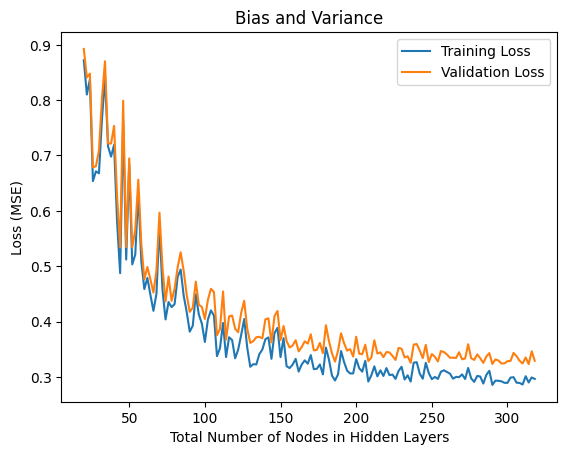

In [33]:
# Initial training
bias_variance_curve = train_increase_complexity(
    X_train, y_train, X_val, y_val,
    hidden_layer_units=[6, 6, 6], activations=best_params[0],
    lr=best_params[1], max_steps=50
)
plot_bias_variance_curve(bias_variance_curve, "Bias and Variance")

Initially, the training and validation losses are similar, indicating high bias and low variance. However, after approximately 75 epochs, the gap between the training and validation losses begins to widen, signaling low bias and high variance.

Training steps: 100%|███████████████████████████████████████████████| 30/30 [39:26<00:00, 78.90s/it]


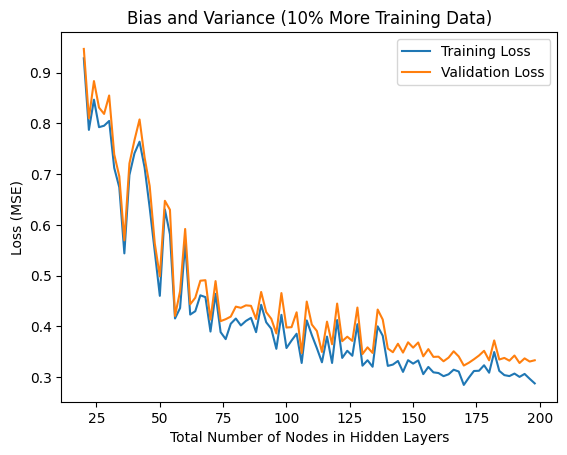

In [34]:
# Increase training set size by 10%
N_train_10p = int(N_train * 0.1)
X_train_10p, y_train_10p = generate_data(N_train_10p)

X_train_concat = np.concatenate((X_train, X_train_10p), axis=0)
y_train_concat = np.concatenate((y_train, y_train_10p), axis=0)

bias_variance_curve_10p = train_increase_complexity(
    X_train_concat, y_train_concat, X_val, y_val,
    hidden_layer_units=[6, 6, 6], activations=best_params[0],
    lr=best_params[1], max_steps=30
)
plot_bias_variance_curve(bias_variance_curve_10p, "Bias and Variance (10% More Training Data)")

Increasing the training data typically helps reduce overfitting, but in this setup, this effect is not clearly observed. Therefore, I will further increase the training dataset to observe its impact.

Training steps: 100%|███████████████████████████████████████████████| 10/10 [14:23<00:00, 86.36s/it]


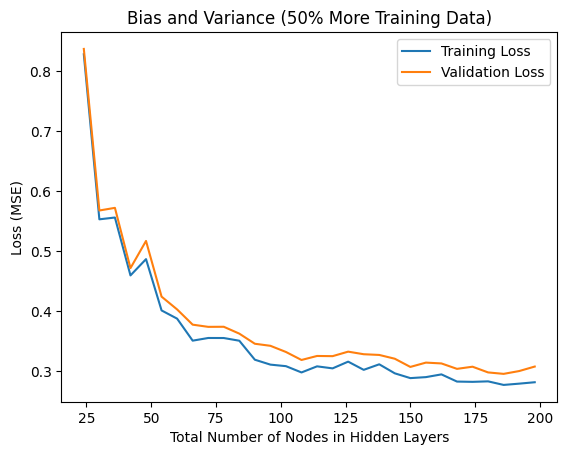

In [11]:
# Increase training set size by 50%
N_train_50p = int(N_train * 0.5)
X_train_50p, y_train_50p = generate_data(N_train_50p)

X_train_concat = np.concatenate((X_train, X_train_50p), axis=0)
y_train_concat = np.concatenate((y_train, y_train_50p), axis=0)

bias_variance_curve_50p = train_increase_complexity(
    X_train_concat, y_train_concat, X_val, y_val,
    hidden_layer_units=[6, 6, 6], activations=best_params[0],
    lr=best_params[1], max_steps=10, step=6
)
plot_bias_variance_curve(bias_variance_curve_50p, "Bias and Variance (50% More Training Data)")

# Part 2: 2D Object Recognition using CNNs

For each 8 shape classes, 128x128 pixels 500 images were generated, featuring various shapes and sizes using [2D Shape Generator](https://github.com/TimoFlesch/2D-Shape-Generator).  

In [20]:
!unzip -q dataset.zip

## Step 1: Generate Dataset with Salt & Pepper Noise

In [21]:
import os
import cv2
import numpy as np

def add_salt_pepper_noise(image, salt_prob=0.02, pepper_prob=0.02):
    noisy = np.copy(image)
    total_pixels = image.size
    num_salt = int(total_pixels * salt_prob)
    num_pepper = int(total_pixels * pepper_prob)

    # Salt (white)
    coords = [np.random.randint(0, i, num_salt) for i in image.shape]
    noisy[coords[0], coords[1]] = 255

    # Pepper (black)
    coords = [np.random.randint(0, i, num_pepper) for i in image.shape]
    noisy[coords[0], coords[1]] = 0

    return noisy

# Paths
original_dataset_path = "dataset"
noisy_dataset_path = "dataset_noisy"

# Create a new directory for noisy images
os.makedirs(noisy_dataset_path, exist_ok=True)

# Apply noise and save images
for folder in os.listdir(original_dataset_path):
    folder_path = os.path.join(original_dataset_path, folder)
    noisy_folder_path = os.path.join(noisy_dataset_path, folder)
    os.makedirs(noisy_folder_path, exist_ok=True)  # Create subfolder in noisy dataset

    for file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            noisy_img = add_salt_pepper_noise(img)
            cv2.imwrite(os.path.join(noisy_folder_path, file), noisy_img)  # Save noisy image

print("Noisy images saved in:", noisy_dataset_path)

Noisy images saved in: dataset_noisy


In [22]:
import tensorflow as tf

batch_size = 32
img_height = 128
img_width = 128

data_dir = noisy_dataset_path

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale')

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale')

class_names = train_ds.class_names
print(class_names)

Found 4000 files belonging to 8 classes.
Using 3200 files for training.
Found 4000 files belonging to 8 classes.
Using 800 files for validation.
['oval', 'poly5', 'poly6', 'poly7', 'rectangle', 'star5', 'star8', 'triangle']


In [23]:
import tensorflow as tf

normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]

# Pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


At fİrst, ı wasn't usİng any normalİzatİon. However, after observİng such a powerful arhcİtecture lİke AlexNet cannot learn to classy 8 shape. Then ı fİgure out that the İmportance of normalİzatİon. After mappİng RGB pİxel values to between 0 and 1, model İmmedİetly started to learn.

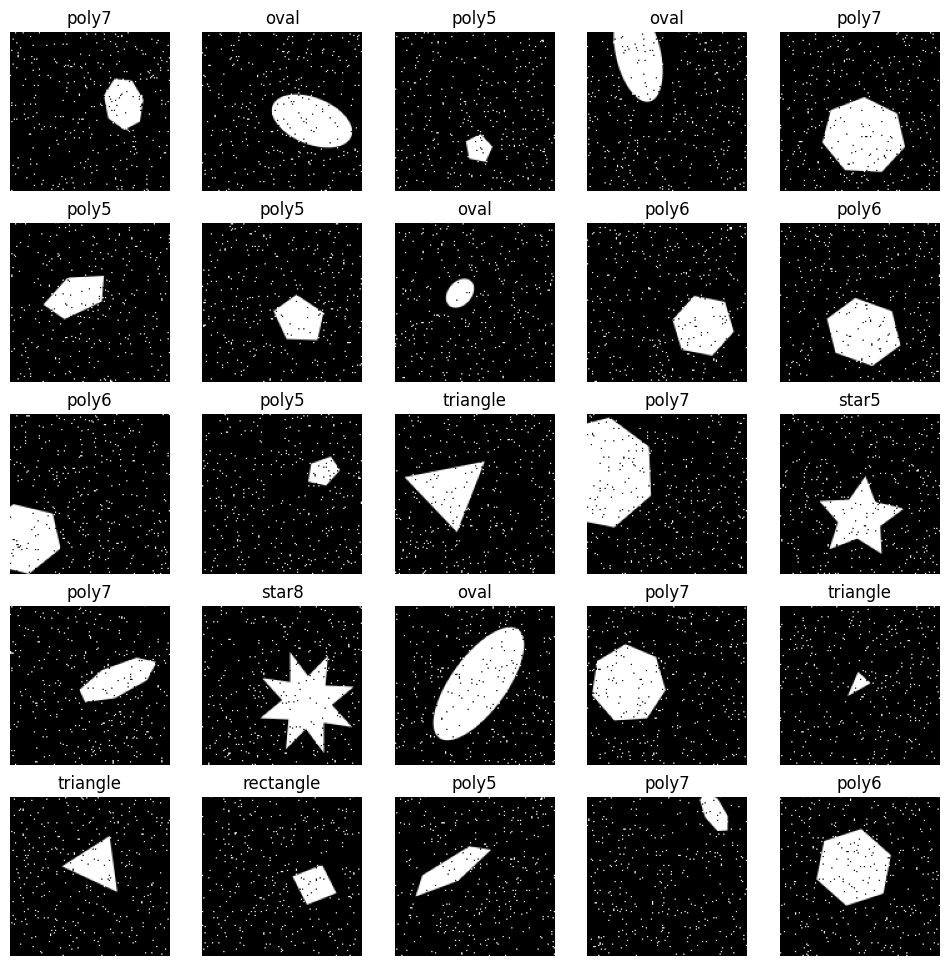

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
for images, labels in val_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")

plt.show()

## Step 2: Build AlexNet

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation

def build_alexnet(fc_nodes=4096, activation="relu", remove_fc=0):
    """
    Builds a modified version of the AlexNet model.

    Original AlexNet Architecture:
    - Accepts input size of (227, 227, 3), but modified here for (128, 128, 1) grayscale images.
    - Uses ReLU activation function in convolutional layers.
    - Has five convolutional layers followed by three fully connected (FC) layers.
    - Uses max pooling and dropout for regularization.
    - Originally designed for 1000-class classification, modified here for 8 classes.

    Modifications:
    - `fc_nodes`: Defines the number of neurons in the fully connected layers (default: 4096).
    - `activation`: Allows selection of different activation functions (default: ReLU).
    - `remove_fc`: Removes the last FC layers based on the value:
      - 0: Keeps all three FC layers.
      - 1: Removes the third FC layer (only two FC layers remain).
      - 2: Removes the second and third FC layers (only one FC layer remains).

    Returns:
    - A compiled Keras model ready for training.
    """
    model = Sequential()
    model.add(Input(shape=(128, 128, 1)))

    # First Convolutional Layer
    model.add(Conv2D(96, (11, 11), strides=4, padding="same"))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    # Second Convolutional Layer
    model.add(Conv2D(256, (5, 5), padding="same"))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    # Third Convolutional Layer
    model.add(Conv2D(384, (3, 3), padding="same"))
    model.add(Activation(activation))

    # Fourth Convolutional Layer
    model.add(Conv2D(384, (3, 3), padding="same"))
    model.add(Activation(activation))

    # Fifth Convolutional Layer
    model.add(Conv2D(256, (3, 3), padding="same"))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    # Flattening layer before FC layers
    model.add(Flatten())

    # Fully connected layers
    if remove_fc < 2:
        model.add(Dense(fc_nodes))
        model.add(Activation(activation))
        model.add(Dropout(0.5))

    if remove_fc < 1:
        model.add(Dense(fc_nodes))
        model.add(Activation(activation))
        model.add(Dropout(0.5))

    # Output layer with 8 classes (softmax activation for classification)
    model.add(Dense(8, activation="softmax"))

    # Compile the model
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    return model

## Step 3: Train the Network

Based on my initial trials, 30 epochs appear to be sufficient.

In [26]:
EPOCHS = 30
BATCH_SIZE = 32

# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [27]:
import matplotlib.pyplot as plt

def plot_training_history(history, subtitle=None):
    # Extract loss and accuracy
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Create the figure
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title("Accuracy")

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Loss")

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.92])

    # Add subtitle at the bottom center
    if subtitle:
        plt.figtext(0.5, 0.01, subtitle, ha='center', fontsize=12, fontstyle='italic')

    plt.show()

Training with activation: tanh and optimizer: SGD
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8330 - loss: 0.4738
Validation accuracy with SGD: 0.8512



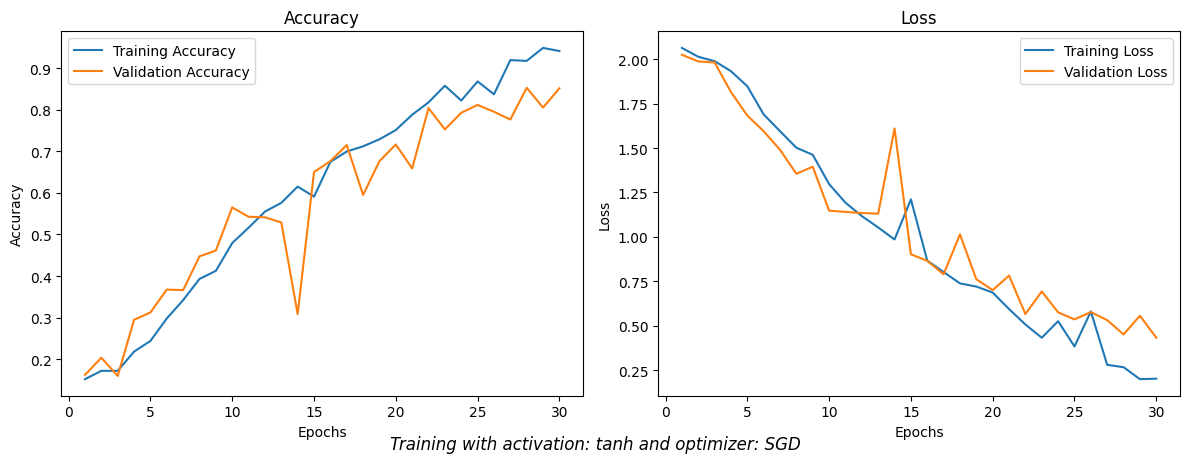

Training with activation: tanh and optimizer: Adam
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1307 - loss: 2.6347
Validation accuracy with Adam: 0.1363



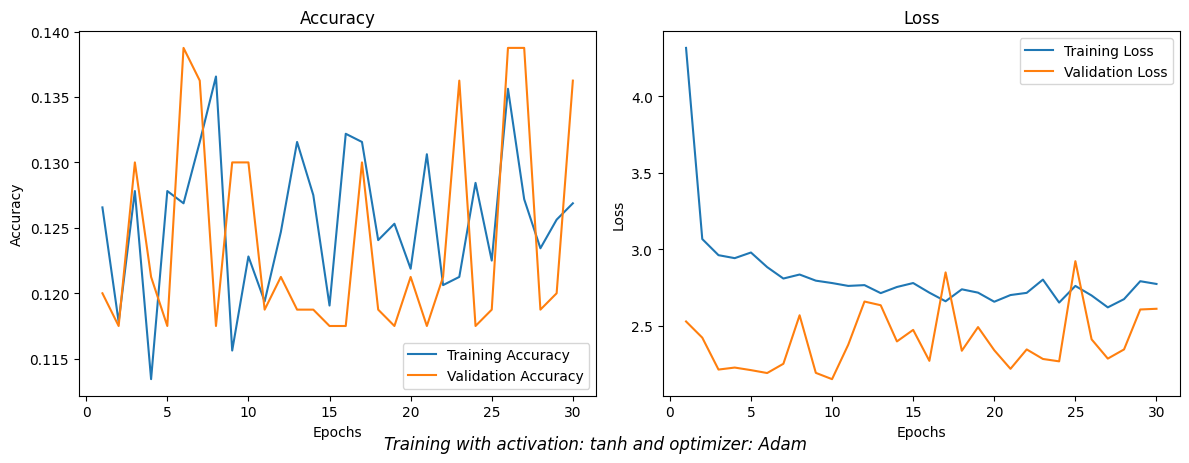

Training with activation: sigmoid and optimizer: SGD
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1215 - loss: 2.0848
Validation accuracy with SGD: 0.1175



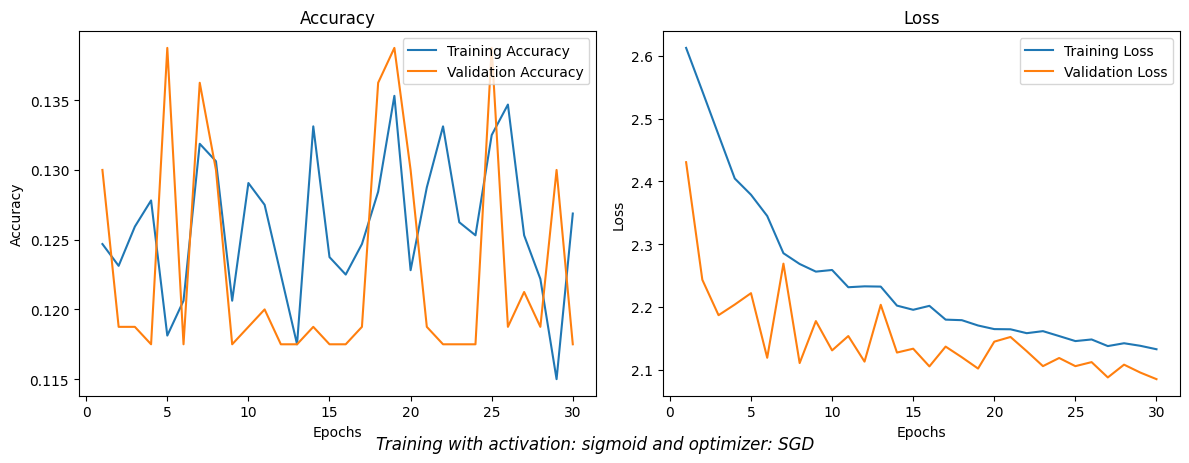

Training with activation: sigmoid and optimizer: Adam
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1267 - loss: 2.1041
Validation accuracy with Adam: 0.1200



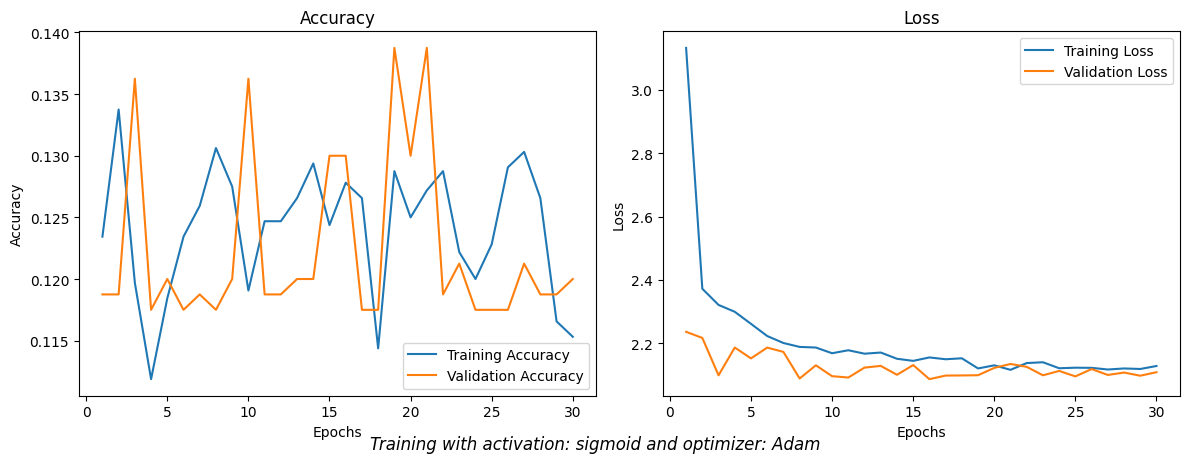

Training with activation: relu and optimizer: SGD
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6271 - loss: 0.8557
Validation accuracy with SGD: 0.6338



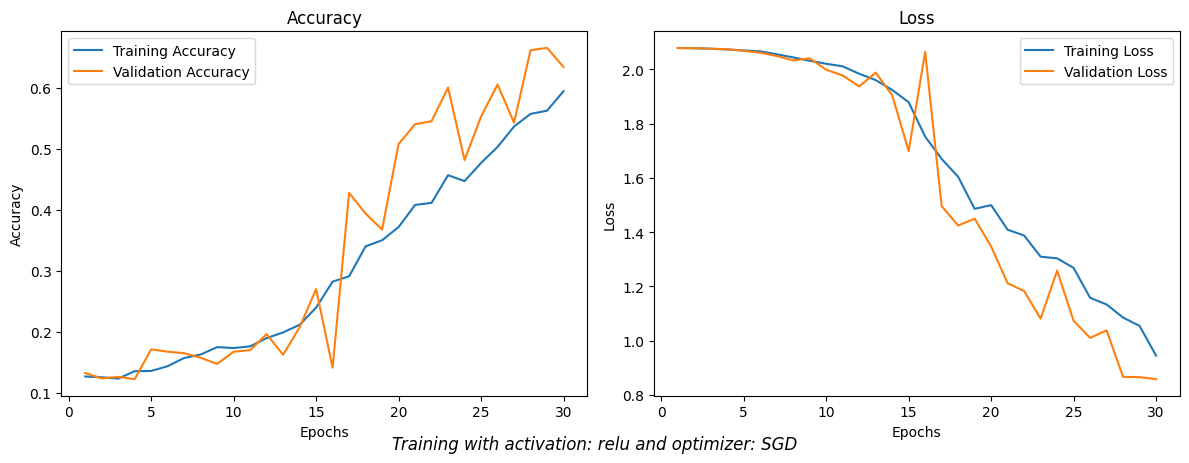

Training with activation: relu and optimizer: Adam
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1267 - loss: 2.0801
Validation accuracy with Adam: 0.1200



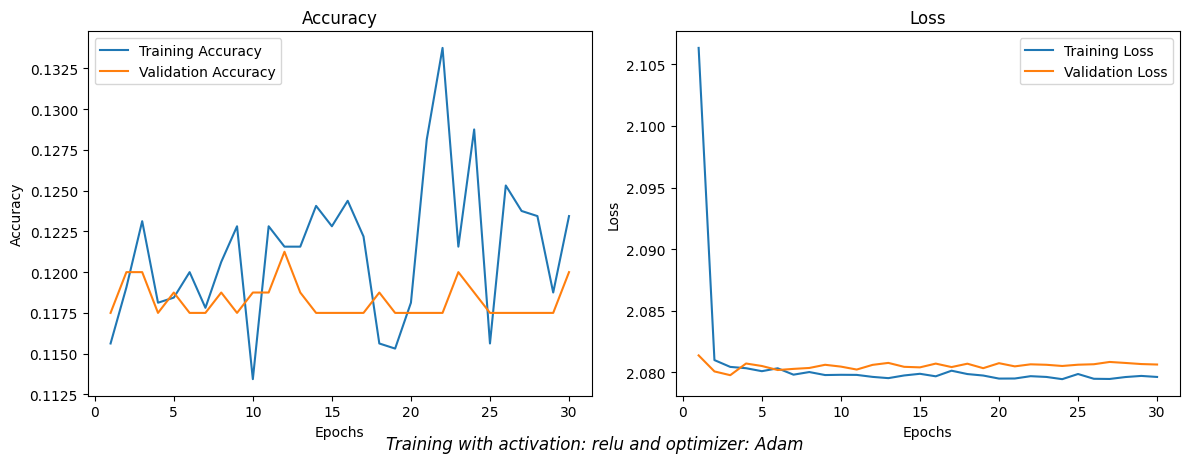

In [28]:
# Three different activation functions
activations = ['tanh', 'sigmoid', 'relu']

# Two different learning rate adjustment shemes: Adam and Stochastic Gradient Descent
optimizers = ["SGD", "Adam"]  # "RMSprop", "Adagrad", etc.

for activation in activations:
    for opt_name in optimizers:
        print(f"Training with activation: {activation} and optimizer: {opt_name}")
        model = build_alexnet(activation=activation)

        # Compile model using optimizer as a string
        model.compile(optimizer=opt_name, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, verbose=0)

        # Evaluate on the validation set
        val_loss, val_acc = model.evaluate(val_ds)
        print(f"Validation accuracy with {opt_name}: {val_acc:.4f}\n")
        plot_training_history(history, subtitle=f"Training with activation: {activation} and optimizer: {opt_name}")

## Step 4: Modify Network Architecture


Training with 4096 nodes in fully connected layers (10% change)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8072 - loss: 0.8002
Validation accuracy: 0.8188



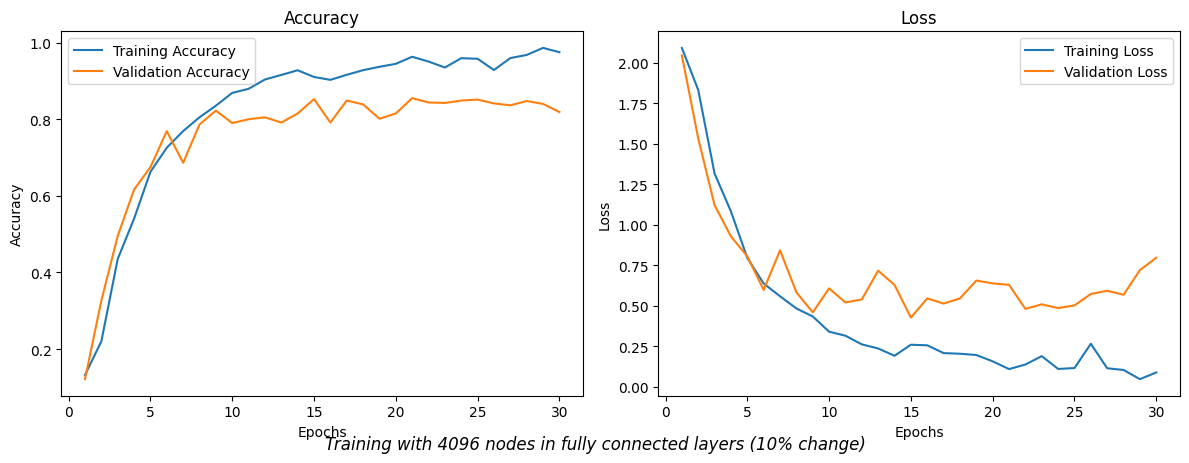


Training with 4505 nodes in fully connected layers (10% change)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1215 - loss: 2.0801
Validation accuracy: 0.1175



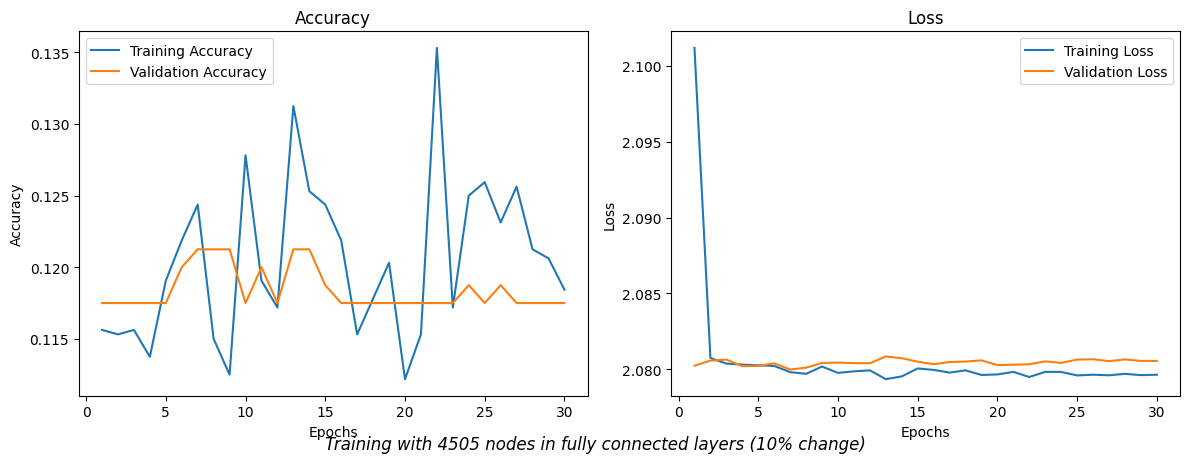


Training with 3686 nodes in fully connected layers (10% change)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1148 - loss: 2.0802
Validation accuracy: 0.1213



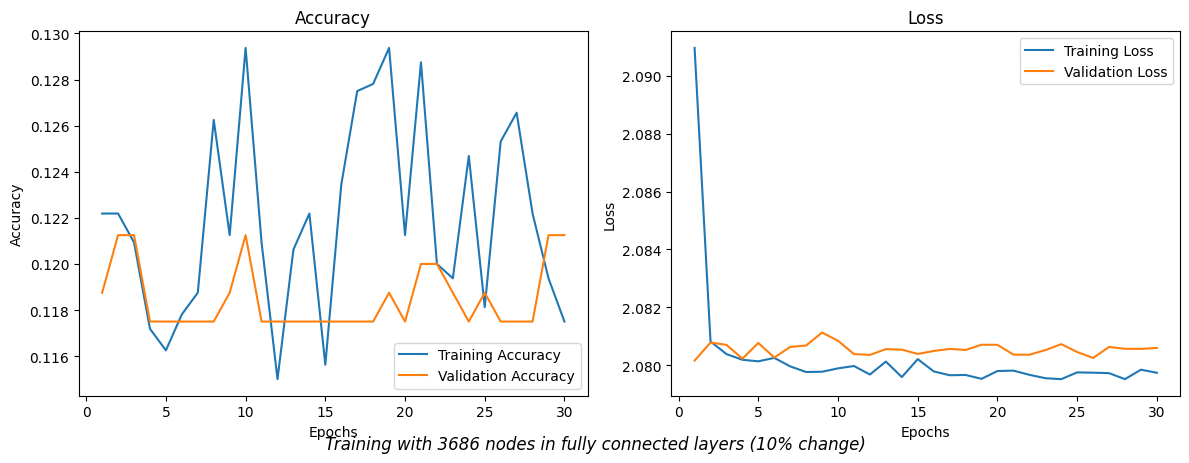

In [29]:
# Experiment 1: Varying the Number of Nodes in Fully Connected Layers by 10%
node_variations = [4096, int(4096 * 1.1), int(4096 * 0.9)]  # 10% increase and decrease
for nodes in node_variations:
    print(f"\nTraining with {nodes} nodes in fully connected layers (10% change)")

    model = build_alexnet(fc_nodes=nodes)
    history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, verbose=0)

    val_loss, val_acc = model.evaluate(val_ds)
    print(f"Validation accuracy: {val_acc:.4f}\n")
    plot_training_history(history, subtitle=f"Training with {nodes} nodes in fully connected layers (10% change)")


Training with 3481 nodes and removing the first fully connected layer (fc1)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1215 - loss: 2.0802
Validation accuracy after removing fc1: 0.1175



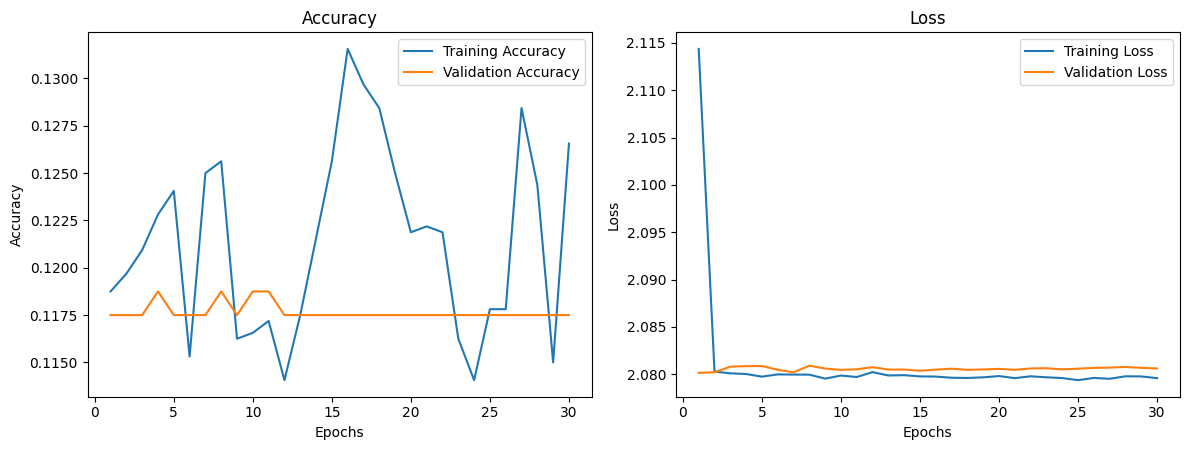

In [30]:
# Experiment 2: Reducing Nodes by 15% and removing the first fully connected layer (fc1 which is third when count from output layer)
nodes_15_percent = int(4096 * 0.85)
print(f"\nTraining with {nodes_15_percent} nodes and removing the first fully connected layer (fc1)")

model = build_alexnet(fc_nodes=nodes_15_percent, remove_fc=1)  # Removing fc1
history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, verbose=0)

val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation accuracy after removing fc1: {val_acc:.4f}\n")
plot_training_history(history)


Training with 3276 nodes and removing both fc1 and fc2, keeping only the output layer (fc3)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8360 - loss: 0.8521
Validation accuracy after removing fc1 and fc2: 0.8375



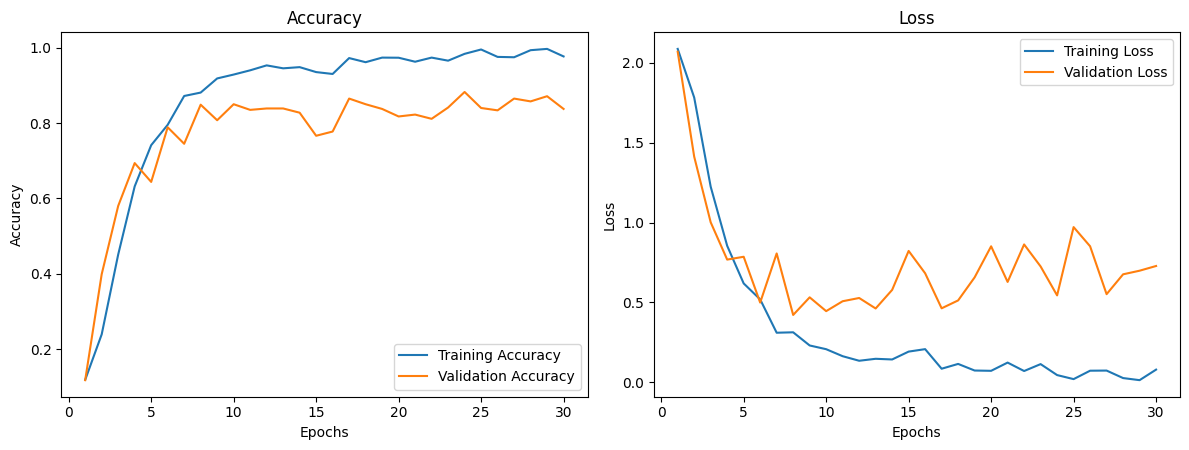

In [31]:
# Experiment 3: Reducing nodes by 20% and removing both fc1 and fc2
nodes_20_percent = int(4096 * 0.8)
print(f"\nTraining with {nodes_20_percent} nodes and removing both fc1 and fc2, keeping only the output layer (fc3)")

model = build_alexnet(fc_nodes=nodes_20_percent, remove_fc=2)  # Removing fc1 and fc2
history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, verbose=0)

val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation accuracy after removing fc1 and fc2: {val_acc:.4f}\n")
plot_training_history(history)

A single fully connected layer appears to be sufficient for the model.